In [1]:
from fy4a import AGRI_L1
import numpy
import matplotlib.pyplot as plt

## 读取原始数据

In [2]:
hdf_path = '/disk2/workspace/20230509/FY4A-_AGRI--_N_DISK_1047E_L1-_FDI-_MULT_NOM_20210619030000_20210619031459_1000M_V0001.HDF'

In [21]:
# 可视化原始圆盘影像
import h5py
def display_original_DF(hdf_path):
    f = h5py.File(hdf_path, 'r')
    dset = f['NOMChannel03'] # DN值
    d_array = numpy.array(dset)
    dset = f['CALChannel03'] # DN值查找表
    c_array = numpy.array(dset)
    dc_array = numpy.copy(d_array)
    dc_array[dc_array>=65534] = 0
    toa_array = c_array[dc_array] # DN值转成TOA真实值
    toa_array[toa_array==0] = numpy.NaN
    f.close()
    plt.imshow(toa_array, interpolation=None)
    plt.colorbar()

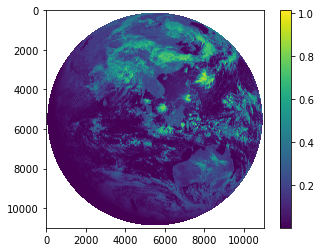

In [22]:
display_original_DF(hdf_path)

## 选择区域投影裁切

In [3]:
def proj_clip_ex(hdf_path, geo_desc, band_name):
    fy4a_file = AGRI_L1(hdf_path, geo_desc)
    reflectance = fy4a_file.extract(band_name)
    return reflectance

In [4]:
geo_desc = [-59.99, 60, 44, 163.99, 0.01]  # 顺序为南、北、西、东、分辨率，即[lat_s, lat_n, lon_w, lon_e, resolution] 中心104.7°
Channel03_reflectance = proj_clip_ex(hdf_path, geo_desc, 'Channel03')
s_array = numpy.array(Channel03_reflectance)

In [25]:
s_array.shape

(12000, 12000)

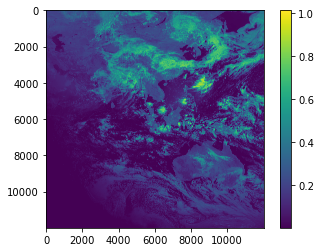

In [26]:
# 可视化裁切投影区域影像
plt.imshow(s_array, interpolation=None)
plt.colorbar()

## 转存为GeoTIFF格式

In [27]:
from osgeo import gdal
from osgeo import osr

In [28]:
def array2geotiff(tif_path, o_array, llon=44., tlat=60., lat_count=12000, lon_count=12000, pixel_resolution=0.01, no_data_value=0.):
    file_format = "GTiff"
    full_geotransform = [llon, pixel_resolution, 0, tlat, 0, -pixel_resolution]
    driver = gdal.GetDriverByName(file_format)
    tif_ds = driver.Create(tif_path, lon_count, lat_count, 1, gdal.GDT_Float32)
    tif_ds.SetGeoTransform(full_geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    tif_ds.SetProjection(srs.ExportToWkt())
    tif_ds.GetRasterBand(1).SetNoDataValue(no_data_value)
    tif_ds.GetRasterBand(1).WriteArray(o_array)
    del tif_ds

In [29]:
tif_path = '/disk2/workspace/20230509/FY4A-_AGRI--_N_DISK_1047E_L1-_FDI-_MULT_NOM_20210619030000_20210619031459_1000M_V0001.tif'
array2geotiff(tif_path, s_array)

## 转存为二进制npy文件

In [31]:
npy_path = '/disk2/workspace/20230509/FY4A-_AGRI--_N_DISK_1047E_L1-_FDI-_MULT_NOM_20210619030000_20210619031459_1000M_V0001.npy'
numpy.save(npy_path, s_array)